#Logistic Regression
* sklearn uses solvers like liblinear, newton-cg, sag, saga and lbfgs to find optimal weights.
* Regularization is applied by default.
* Some important parameters:
  * Regularization: penalty='l2'
  * Regularization rate: C=1
  * Solver: solver='lbfgs
* Let us implement Logistic Regression without regularization by setting the parameter C = $∞$. Therefor we may expect performance close to SGDClassifier without regularization.

In [ ]:
import numpy as np
import os
import io
import warnings

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegressionCV
from sklearn.metrics import hinge_loss
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score, log_loss
from sklearn.model_selection import cross_validate, cross_val_predict, GridSearchCV, RandomizedSearchCV
from pprint import pprint

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from scipy.stats import loguniform
np.random.seed(42)

#global settings
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', figsize=(8,6))

In [ ]:
#Ignore all warnings
def warn(*args, **kwargs):
  pass
warnings.warn = warn

In [ ]:
X_pd, y_pd = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X_pd.to_numpy()
y = y_pd.to_numpy()

In [ ]:
X_train, X_test, y_train, y_test  = X[:60000], X[60000:], y[:60000], y[60000:]

In [ ]:
y_train_0 = np.zeros((len(y_train)))
y_test_0 = np.zeros((len(y_test)))

#find the indices of digit 0
indx_0 = np.where(y_train == '0') # oroginal labels are str, not int
#use these indices to modify y_train_0 and y_test_0
y_train_0[indx_0] = 1 
indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

##Training without Regularization
* Step1: Instantiate Pipeline object with two stages
  * The first stage contains MinMaxScaler for scaling the input.
  * The second stage contains a LogisticRegression classifier with the regularization rate C=infinity.
* Step2: Train the pipeline with feature matrix X_train and label vector y_train_0

In [ ]:
pipe_logit = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=1729, solver='lbfgs', C=np.infty))
pipe_logit.fit(X_train, y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=inf, random_state=1729))])

#HyperParameter Search
##With GridSearchCV
In previous step, we trained Logistic Regression with default parameterization.   
Now we will demonstrate how to search for the best parameter value for regularization rate C, using GridSearchCV


In order to use GridSearchCV, we first define a set of values that we want to try for C. The best value of C will be found from this set. 

We define pipeline object exactly like before with one exception: we have set parameter value C to 1 in LogisticRegression estimator. You can set it to any value, as the best value would be searched with grid search.

The additional step here is to instantiate a GridSearchCV object with a pipeline estimator, parameter grid specification and f1 as a scoring function.
* Note that you can use other scoring functions like precision, recall, however the value of C is found such that the given scoring function is optimized. 

In [ ]:
from sklearn.pipeline import Pipeline
grid_Cs = [0, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]
scaler = MinMaxScaler()
logreg = LogisticRegression(C=1.0, random_state=1729)
pipe = Pipeline(steps=[('scaler', scaler),
                       ('logistic', logreg)
                       ])
pipe_logit_cv = GridSearchCV(pipe,
                             param_grid={'logistic__C':grid_Cs},
                             scoring='f1'
                             )
pipe_logit_cv.fit(X_train, y_train_0)

GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('logistic',
                                        LogisticRegression(random_state=1729))]),
             param_grid={'logistic__C': [0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0,
                                         100.0]},
             scoring='f1')

In [ ]:
pipe_logit_cv.best_params_

{'logistic__C': 0.1}

In [ ]:
pipe_logit_cv.best_score_

0.9579654953103655

In [ ]:
pipe_logit_cv.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('logistic', LogisticRegression(C=0.1, random_state=1729))])

###With LogisticRegressionCV
Instead of using GridSearchCV for finding the best value for parameter C, we can use LogisticRegressionCV for performing the same job.
* STEP1: Here we make use of LogisticRegressionCV estimetor with number of cross validation folds cv=5, and scoring scheme, scoring='f1' in the pipeline object. 
* STEP2: In the second step, we train the pipeline object as before.

In [ ]:
estimator = LogisticRegressionCV(cv=5, scoring='f1', random_state=1729)
logit_cv = make_pipeline(MinMaxScaler(), estimator)
logit_cv.fit(X_train, y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregressioncv',
                 LogisticRegressionCV(cv=5, random_state=1729, scoring='f1'))])

By default LogisticRegressionCV refits the model on the entire training set with the best parameter values obtained via cross validation.

##Performance Evaluation
###Precision, Recall, F1 Score
Let us evaluate the performance of these three different logistic regression classifiers for detecting 0 digit from the image.
* Logistic Regression without regularization.
* Best Logistic regression classifier found through GridSearchCV.
* Best classifier found thru LogisticRegressionCV.

GridSearchCV and LogisticRegressionCV by default refit the classifier for the best hyperparameter values.

Let us get prediction for test set with these three classifiers.

In [ ]:
lr_y_hat_0 = pipe_logit.predict(X_test)
lr_gs_y_hat_0 = pipe_logit_cv.best_estimator_.predict(X_test)
lr_cv_y_hat_0 = pipe_logit_cv.predict(X_test)

In [ ]:
precision_lr = precision_score(y_test_0, lr_y_hat_0)
recall_lr = recall_score(y_test_0, lr_y_hat_0)

precision_lr_gs = precision_score(y_test_0, lr_gs_y_hat_0)
recall_lr_gs = recall_score(y_test_0, lr_gs_y_hat_0)

precision_lr_cv = precision_score(y_test_0, lr_cv_y_hat_0)
recall_lr_cv = recall_score(y_test_0, lr_cv_y_hat_0)

In [ ]:
print('LogReg Precision: ', precision_lr, 'Recall: ', recall_lr)
print('GridSearch Precision: ', precision_lr_gs, 'Recall: ', recall_lr_gs)
print('LogRegCV Precision: ', precision_lr_cv, 'Recall: ', recall_lr_cv)

LogReg Precision:  0.9515151515151515 Recall:  0.9612244897959183
GridSearch Precision:  0.9564336372847011 Recall:  0.963265306122449
LogRegCV Precision:  0.9564336372847011 Recall:  0.963265306122449


###Using PR-Curve

In [ ]:
y_scores_lr = pipe_logit.decision_function(X_test)
precisions_lr, recalls_lr, thresholds_lr = precision_recall_curve(y_test_0, y_scores_lr)

y_scores_lr_gs = pipe_logit_cv.decision_function(X_test)
precisions_lr_gs, recalls_lr_gs, thresholds_lr_gs = precision_recall_curve(y_test_0, y_scores_lr_gs)

y_scores_lr_cv = logit_cv.decision_function(X_test)
precisions_lr_cv, recalls_lr_cv, thresholds_lr_cv = precision_recall_curve(y_test_0, y_scores_lr_cv)

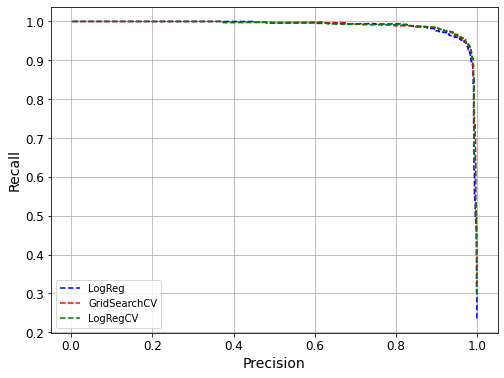

In [ ]:
plt.figure()
plt.plot(recalls_lr[:-1], precisions_lr[:-1], 'b--', label='LogReg')
plt.plot(recalls_lr_gs[:-1], precisions_lr_gs[:-1], 'r--', label='GridSearchCV')
plt.plot(recalls_lr_cv[:-1], precisions_lr_cv[:-1], 'g--', label='LogRegCV')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid(True)
plt.legend()
plt.show()

Note that PR Curves for all three classes overlap significantly.

Let us calculate the are under PR Curve

In [ ]:
from sklearn.metrics import auc
auc_lr = auc(recalls_lr[:-1], precisions_lr[:-1])
auc_lr_gs = auc(recalls_lr_gs[:-1], precisions_lr_gs[:-1])
auc_lr_cv = auc(recalls_lr_cv[:-1], precisions_lr_cv[:-1])

print('AUC-PR for Logistic Regression: ', auc_lr)
print('AUC-PR for GridSearchCV: ', auc_lr_gs)
print('AUC-PR for Logistic RegressionCV: ', auc_lr_cv)

AUC-PR for Logistic Regression:  0.9871337497759658
AUC-PR for GridSearchCV:  0.9886520703587929
AUC-PR for Logistic RegressionCV:  0.9886328332116212


AUC for all three classifiers are roughly the same with LogisticRegression Classifier obtained thru CV and gridsearch are slighly higher AUC under PR Curve.

###Confusion Matrix
*For LogisticRegression Classifier

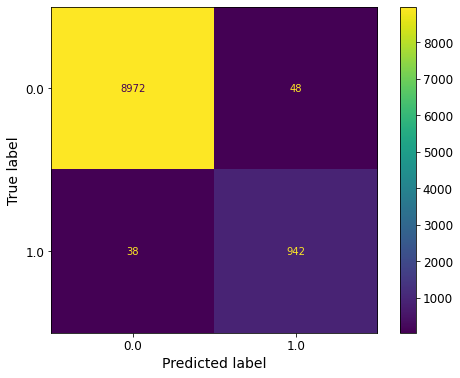

In [ ]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, lr_y_hat_0, values_format='.5g')
plt.show()

* Confusion Matrix for GridSearchCV

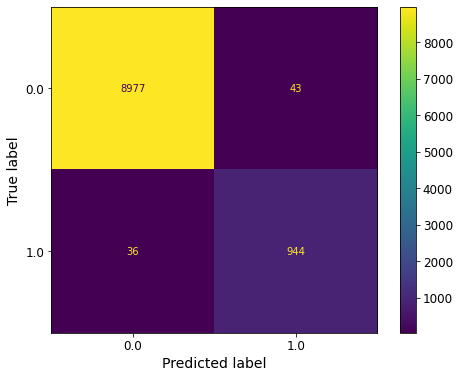

In [ ]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, lr_gs_y_hat_0, values_format='.5g')
plt.show()

* Confudion Matrix for LogisticRegressionCV

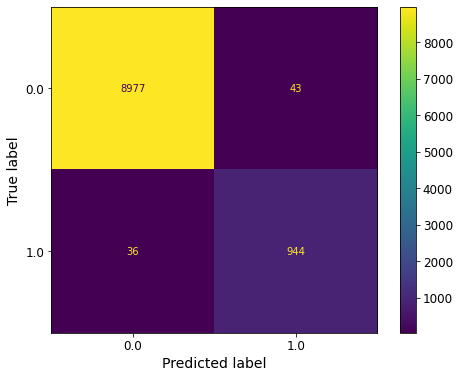

In [ ]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, lr_cv_y_hat_0, values_format='.5g')
plt.show()